##Loading libraries


##check this tutorial !!??

https://pyimagesearch.com/2021/10/11/pytorch-transfer-learning-and-image-classification/

In [1]:
import torch
import torch.nn as nn
from math import ceil
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import models, transforms
import time
from torchvision import datasets
from torchvision.datasets import ImageFolder
from zipfile import ZipFile
import os
import glob
import numpy as np
import requests
from collections import Counter

In [2]:
!nvidia-smi

Tue Feb 13 16:05:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import torch
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# @title unzip the datasetfile
file_name='Alzhamier.zip'
with ZipFile(file_name,'r') as zip:
  #zip.printdir()
  #extracting all the files
  print('Extracting all the files now ...')
  zip.extractall()
  print('Done!')


Extracting all the files now ...
Done!


In [5]:
##Function to store all the files in an array

def get_all_file_paths(directory):
  #initializing empty file paths list
  file_paths=[]
  #crawling through directory and subdirectories
  for root , directories ,files in os.walk (directory):
    for filename in files:
      #join the two strings in order to form the full fi
      filepath=os.path.join(root, filename)
      file_paths.append(filepath)
  return file_paths


In [6]:
Test_dir='/content/Alzheimer_s Dataset/test'
Train_dir='/content/Alzheimer_s Dataset/train'
train_paths=get_all_file_paths(Train_dir)
test_paths=get_all_file_paths(Test_dir)

In [7]:
print(f'the train dataset consists of {len(train_paths)} images ')
print(f'the test dataset consists of {len(test_paths)} images')

the train dataset consists of 5121 images 
the test dataset consists of 1279 images


In [8]:
# Target labels
targets = ["MildDemented","ModerateDemented","NonDemented","VeryMildDemented"]
dataset = ["test","train"]
test_dict = {}
train_dict = {}
for target in targets:
    test_dict[target] = glob.glob(f"/content/Alzheimer_s Dataset/test/{target}/*")
    train_dict[target] = glob.glob(f"/content/Alzheimer_s Dataset/train/{target}/*")

In [9]:
test_class_dict={key:len(value) for key ,value in test_dict.items()}
train_class_dict={key:len(value) for key , value in train_dict.items()}

##class labels distribution in the dataset

In [10]:
print(f'the test dataset contains {test_class_dict} images')
print(f'the train dataset contains {train_class_dict}  images')

the test dataset contains {'MildDemented': 179, 'ModerateDemented': 12, 'NonDemented': 640, 'VeryMildDemented': 448} images
the train dataset contains {'MildDemented': 717, 'ModerateDemented': 52, 'NonDemented': 2560, 'VeryMildDemented': 1792}  images


In [11]:
# @title Exploring the distribution of the Train and Test Dataset
total_observations = np.sum(list(test_class_dict .values()))
print(total_observations)
print(list(test_class_dict .values()))
class_weights = np.array(list(test_class_dict .values()))/total_observations

print(f"Number of total observations in the Train dataset: {total_observations}\n")
print(f"Class distributions in the complete train dataset: {np.round(class_weights,2)*100}%\n")

total_observations = np.sum(list(train_class_dict .values()))
class_weights = np.array(list(train_class_dict .values()))/total_observations

print(f"Number of total observations in the Test dataset: {total_observations}\n")
print(f"Class distributions in the complete Tset dataset: {np.round(class_weights,2)*100}%\n")

1279
[179, 12, 640, 448]
Number of total observations in the Train dataset: 1279

Class distributions in the complete train dataset: [14.  1. 50. 35.]%

Number of total observations in the Test dataset: 5121

Class distributions in the complete Tset dataset: [14.  1. 50. 35.]%



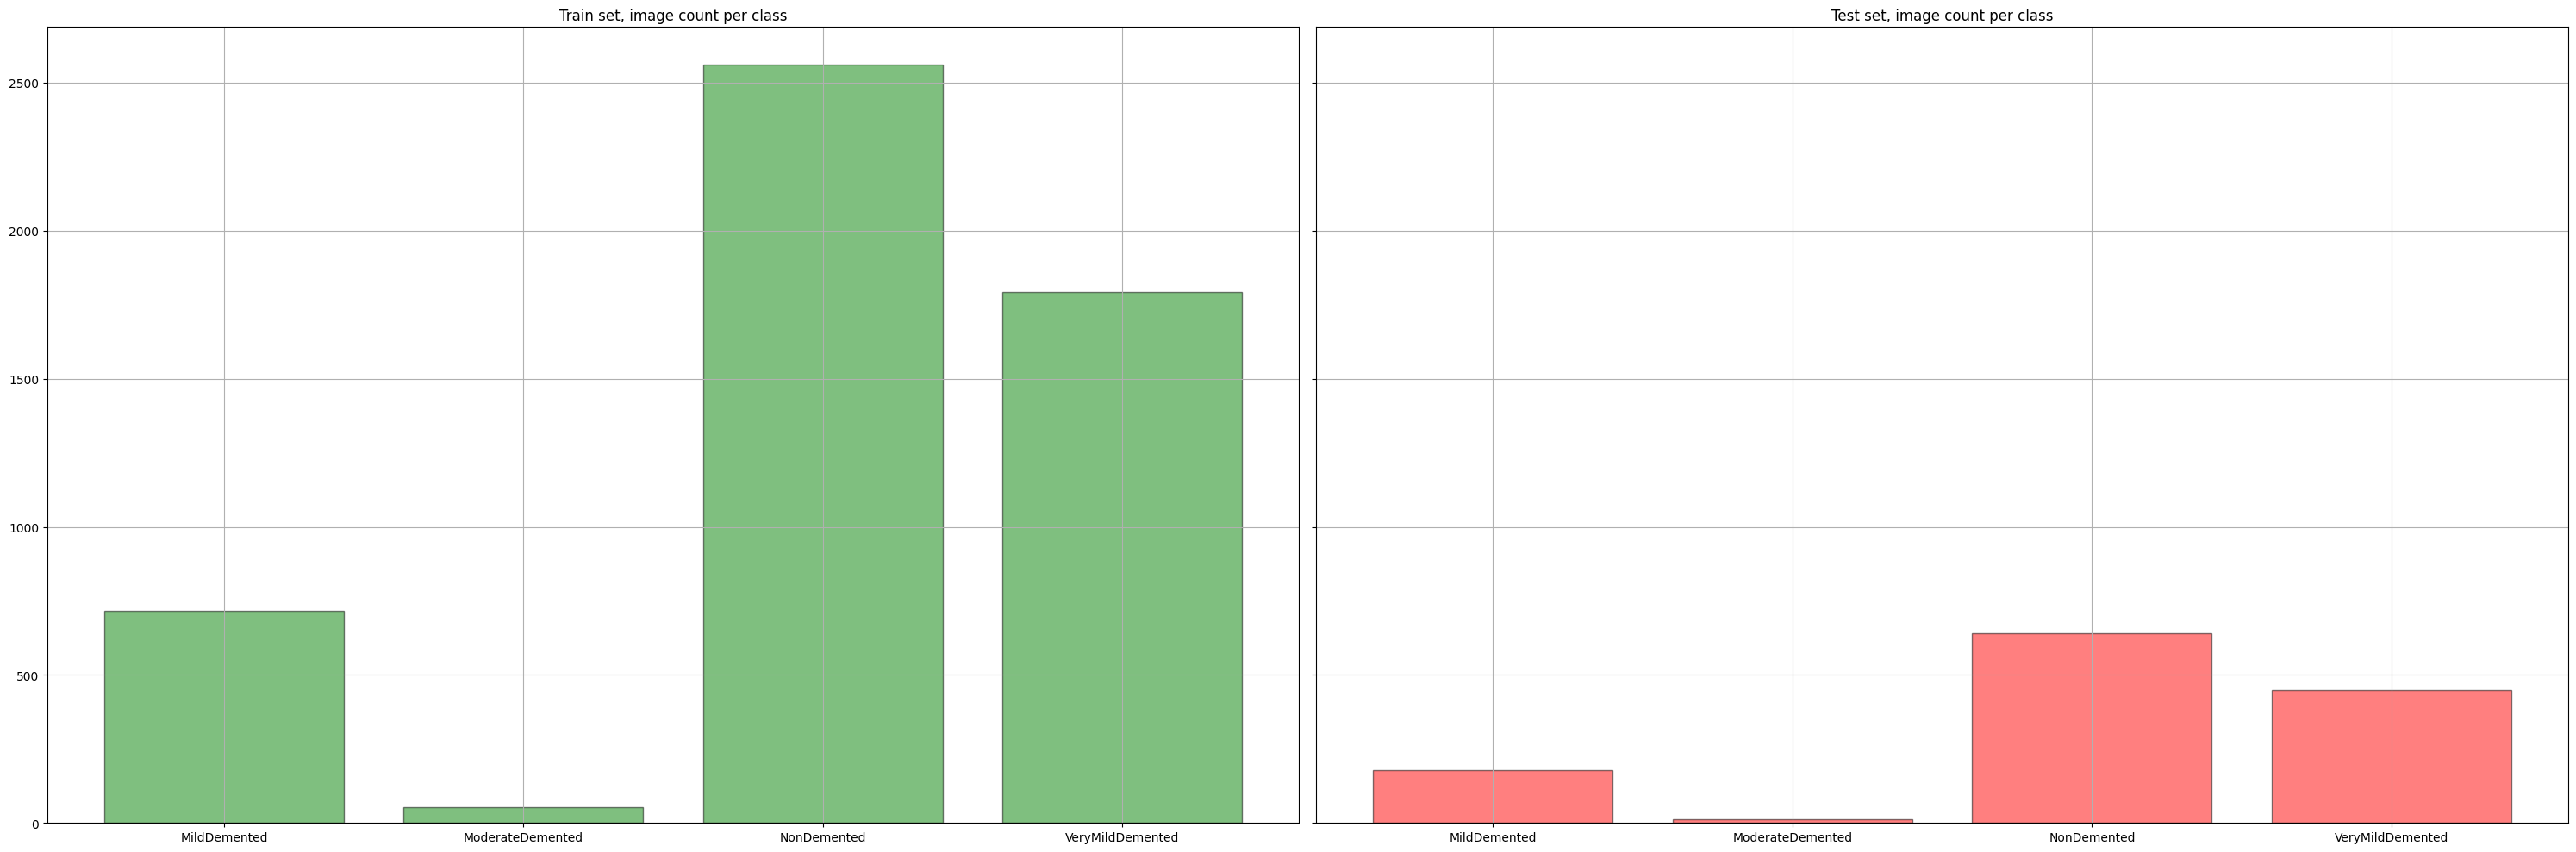

In [12]:
# @title Visualizing & imbalance investigation


fig, axes = plt.subplots(1, 2, figsize=(30, 10), sharey=True)

axes[0].bar(x=list(train_class_dict.keys()), height=list(train_class_dict.values()), color='green', edgecolor='k', alpha=0.5)
axes[0].set_title('Train set, image count per class')
axes[0].grid()

axes[1].bar(x=list(test_class_dict.keys()), height=list(test_class_dict.values()), color='red', edgecolor="k", alpha=0.5)
axes[1].set_title('Test set, image count per class')  # Corrected 'set_tittle' to 'set_title'
axes[1].grid()

plt.tight_layout()
plt.show()


In [13]:
class_labels = {0:"MildDemented",
                1:"ModerateDemented",
                2:"NonDemented",
                3:"VeryMildDemented" }

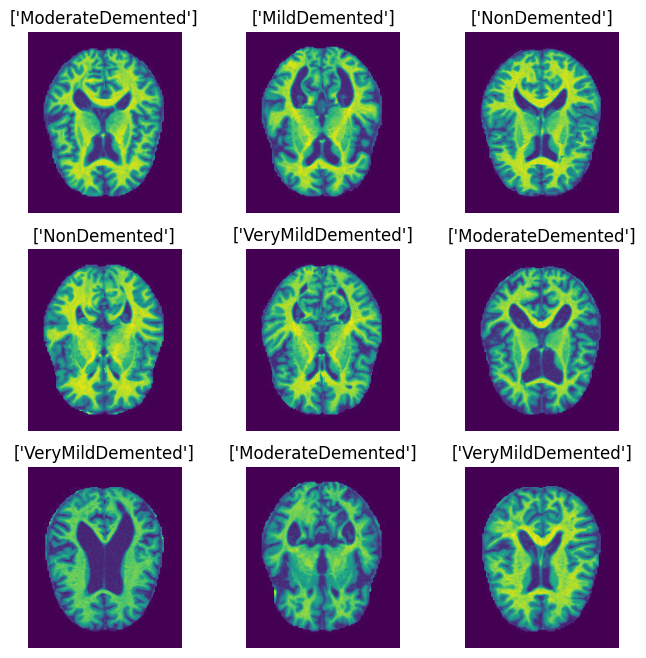

In [14]:
figure = plt.figure (figsize=(8,8))
cols , rows =3, 3
for i in range (1, cols * rows + 1):
  key = torch.randint (len (targets) , size=(1,)).item()
  target=targets[key]
  sample_idx=torch.randint(len(train_dict[target]), size=(1,)).item()
  file_path = train_dict[target][sample_idx]
  img=mpimg.imread (file_path)
  figure.add_subplot(rows , cols , i)
  plt.title([target])
  plt.axis('off')
  plt.imshow(img)
plt.show()




In [15]:
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [16]:
import pandas as pd

In [17]:
data = pd.DataFrame(columns=['image', 'label'])
for key , values in train_dict.items():
 for value in values:
        data = data.append({'image': value, 'label': key}, ignore_index=True)

In [18]:
for key , values in test_dict.items():
 for value in values:
        data = data.append({'image': value, 'label': key}, ignore_index=True)

In [19]:
import torch
import torchvision
from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
except :
  print('[Info] Couldnt find torchinfo .... installing it')
  !pip install -q torchinfo
  from torchinfo import summary


try:
  from going_modular.going_modular import data_setup , engine
except:
  print ('[INFO ]couldnot find going_modular scripts ... downloading them from GitHub')
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine


[Info] Couldnt find torchinfo .... installing it
[INFO ]couldnot find going_modular scripts ... downloading them from GitHub
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Counting objects: 100% (4056/4056), done.
remote: Compressing objects: 100% (1626/1626), done.
remote: Total 4056 (delta 2387), reused 3946 (delta 2369), pack-reused 0
Receiving objects: 100% (4056/4056), 649.87 MiB | 47.52 MiB/s, done.
Resolving deltas: 100% (2387/2387), done.
Updating files: 100% (248/248), done.


In [20]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT  # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_V2_S_Weights.IMAGENET1K_V1

The benefit of automatically creating a transform through weights.transforms() is that you ensure you're using the same data transformation as the pretrained model used when it was trained

In [21]:
auto_transforms=weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [22]:

model=torchvision.models.efficientnet_v2_s(weights=weights).to (device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:04<00:00, 20.3MB/s]


In [23]:
## Getting a summary of our model
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(32, 3, 384, 384), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 384, 384]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 384, 384]    [32, 1280, 12, 12]   --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 384, 384]    [32, 24, 192, 192]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 384, 384]    [32, 24, 192, 192]   648                  True
│    │    └─BatchNorm2d (1)                                  [32, 24, 192, 192]   [32, 24, 192, 192]   48                   True
│    │    └─SiLU (2)                                         [32, 24, 192, 192]   [32, 24, 192, 192]   --                   --
│    └─Sequential (1)                                        [32, 24, 192, 192]   [32, 24, 192

From the output of the summary, we can see all of the various input and output shape changes as our image data goes through the model.

And there are a whole bunch more total parameters (pretrained weights) to recognize different patterns in our data.

you can customise the outputs of a pretrained model by changing the output layer(s) to suit your problem. The original torchvision.models.efficientnet_b0() comes with out_features=1280 because there are 1280 classes in ImageNet, the dataset it was trained on. However, for our problem, classifying images of stages of alzhameir we only need out_features=4.

We can freeze all of the layers/parameters in the features section by setting the attribute requires_grad=False.

For parameters with requires_grad=False, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

In essence, a parameter with requires_grad=False is "untrainable" or "frozen" in place

In [24]:
'''for param in model.features.parameters():
  param.requires_grad=False'''

'for param in model.features.parameters():\n  param.requires_grad=False'

In [25]:
# set the manual_seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of our class output
output_class=len(targets)
#print(output_class)
#Recreate the classifier layer and seed it to the target device

model.classifier=torch.nn.Sequential (
    torch.nn.Dropout(p=0.5 , inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_class,
                    bias=True)).to(device)





In [26]:
# get the number of input features for the final layer
num_ftrs = model.classifier[1].out_features
num_ftrs

4

In [27]:
num_ftrs = model.classifier[1].in_features
num_ftrs

1280

In [28]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        input_size=(32, 3,384, 384), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 384, 384]    [32, 4]              --                   True
├─Sequential (features)                                      [32, 3, 384, 384]    [32, 1280, 12, 12]   --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 384, 384]    [32, 24, 192, 192]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 384, 384]    [32, 24, 192, 192]   648                  True
│    │    └─BatchNorm2d (1)                                  [32, 24, 192, 192]   [32, 24, 192, 192]   48                   True
│    │    └─SiLU (2)                                         [32, 24, 192, 192]   [32, 24, 192, 192]   --                   --
│    └─Sequential (1)                                        [32, 24, 192, 192]   [32, 24, 192

In [29]:
data

,image,label
0,/content/Alzheimer_s Dataset/train/MildDemente...,MildDemented
1,/content/Alzheimer_s Dataset/train/MildDemente...,MildDemented
2,/content/Alzheimer_s Dataset/train/MildDemente...,MildDemented
3,/content/Alzheimer_s Dataset/train/MildDemente...,MildDemented
4,/content/Alzheimer_s Dataset/train/MildDemente...,MildDemented
...,...,...
6395,/content/Alzheimer_s Dataset/test/VeryMildDeme...,VeryMildDemented
6396,/content/Alzheimer_s Dataset/test/VeryMildDeme...,VeryMildDemented
6397,/content/Alzheimer_s Dataset/test/VeryMildDeme...,VeryMildDemented
6398,/content/Alzheimer_s Dataset/test/VeryMildDeme...,VeryMildDemented


In [30]:
merged_dict = {key: [test_class_dict[key]+ train_class_dict[key]] for key in test_class_dict}

print(merged_dict)

{'MildDemented': [896], 'ModerateDemented': [64], 'NonDemented': [3200], 'VeryMildDemented': [2240]}


##Train Model


## calculate the weight of each class

In [31]:

total_imgs = data.shape[0]
num_classes = len(np.unique(data.label))

# Combine the image counts from both test and train sets
img_per_class = {key: test_class_dict[key] + train_class_dict[key] for key in test_class_dict}

# Calculate the weights
weights = torch.tensor([total_imgs / (class_imgs * num_classes) for class_imgs in img_per_class.values()]).to(device)

print(weights)



tensor([ 1.7857, 25.0000,  0.5000,  0.7143], device='cuda:0')


In [32]:
# @title Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.01)

##Prepare dataset for cross validation
Load dataset with different transforms for the train and test splits. The transforms used are the ones the pretrained model weights were optimized on. Using the same transforms usually yields better performance when fine-tuning or using the model for feature extraction.

It is important to make sure that all values are scaled to the range [0..1] before we pass them to a neural network - it is the usual convention for data preparation, and all default weight initializations in neural networks are designed to work with this range. The transform.ToTensor() method does this tranformation.

It is important to note that all images should be scaled to the same size. The transform.Resize() method performs bilinear interpolation by default. Since our images are already in the size of 384x384 or smaller we decided not to first resize to 384 and then crop to 384 as the pretrained model suggests, in feat of losing information. We only resized them all to 384*384

Normalization is done with the ImageNet means and stds.

The test set will be held out separately for testing the final model after cross validation

In [33]:
train_transforms = transforms.Compose([
    # data augmentations can go here
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [34]:
from sklearn.model_selection import train_test_split
x=data['image']
y=data['label']
x_train,x_test,y_train,y_test=train_test_split(x,y , test_size=0.3,random_state=42)

In [35]:
train_dataset = ImageFolder(Train_dir, transform=auto_transforms)
test_dataset = ImageFolder(Test_dir, transform=auto_transforms)

In [36]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 1279
    Root location: /content/Alzheimer_s Dataset/test
    StandardTransform
Transform: ImageClassification(
               crop_size=[384]
               resize_size=[384]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )

In [37]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 5121
    Root location: /content/Alzheimer_s Dataset/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[384]
               resize_size=[384]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )

In [38]:
def create_efficientnet_v2custom(num_classes, seed=42):
    """
    Create an EfficientNetB0 model with custom modifications.

    Args:
        num_classes (int): Number of output classes.
        seed (int): Random seed for reproducibility (default: 42).

    Returns:
        model (nn.Module): Custom EfficientNetB0 model.
    """
    # Set random seeds for reproducibility
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    # Load the pretrained EfficientNetB0 model from torchvision
    weights= torchvision.models.EfficientNet_V2_S_Weights.DEFAULT # .DEFAULT = best available weights
    model = torchvision.models.efficientnet_v2_s(weights=weights)

    # Modify the final fully connected layer for the desired number of output classes
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = torch.nn.Linear(num_ftrs, num_classes)
    model.to(device)

    return model

In [39]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [40]:
import engine , helper_functions

In [41]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#start the timer
from timeit import default_timer as timer
start_time=timer()
results_all=[]
model= create_efficientnet_v2custom(num_classes).to(device)

# Set the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.01)

print('Model was reset')
results, model_ = engine.train_with_early_stopping(model=model,
                                              train_dataloader=train_loader ,
                                              valid_dataloader=test_loader,
                                              optimizer=optimizer,
                                              loss_fn=loss_fn,
                                              epochs=10,
                                              device=device)

results_all.append(results)

end_time=timer()
print(f'[INFO] total training time :{end_time-start_time:.3f} seconds')

Model was reset


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8126 | train_bal_acc: 0.5100 | train_mcc: 0.3812 | valid_loss: 0.7770 | valid_bal_acc: 0.5439 | valid_mcc: 0.4573
Epoch: 2 | train_loss: 0.2820 | train_bal_acc: 0.8687 | train_mcc: 0.8354 | valid_loss: 0.8707 | valid_bal_acc: 0.5953 | valid_mcc: 0.5216
Epoch: 3 | train_loss: 0.1092 | train_bal_acc: 0.9595 | train_mcc: 0.9385 | valid_loss: 0.7726 | valid_bal_acc: 0.7452 | valid_mcc: 0.6494
Epoch: 4 | train_loss: 0.0558 | train_bal_acc: 0.9813 | train_mcc: 0.9633 | valid_loss: 0.8264 | valid_bal_acc: 0.7138 | valid_mcc: 0.5940
Epoch: 5 | train_loss: 0.0513 | train_bal_acc: 0.9859 | train_mcc: 0.9657 | valid_loss: 0.9605 | valid_bal_acc: 0.6666 | valid_mcc: 0.5649
Epoch: 6 | train_loss: 0.0523 | train_bal_acc: 0.9770 | train_mcc: 0.9700 | valid_loss: 0.9710 | valid_bal_acc: 0.6966 | valid_mcc: 0.6125
Epoch: 7 | train_loss: 0.0398 | train_bal_acc: 0.9890 | train_mcc: 0.9772 | valid_loss: 0.8680 | valid_bal_acc: 0.7479 | valid_mcc: 0.6508
Epoch: 8 | train_loss: 0.02

In [42]:
torch.save(model_.state_dict(), 'model_weights.pth')

   Balanced Acc       MCC  F1 score
0      0.745223  0.649382   0.77888


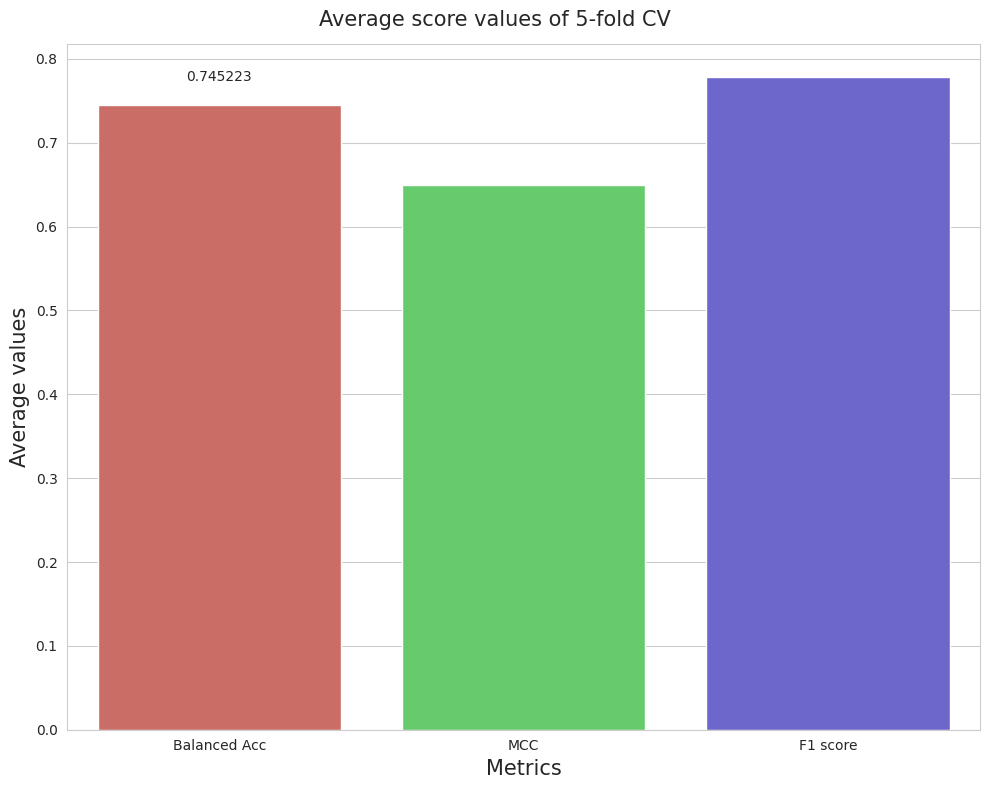

In [43]:

my_dict = {'Balanced Acc': [results_all[i]['valid_bal_acc'][results_all[i]['valid_loss'].index(min(results_all[i]['valid_loss']))] for i in range(len(results_all))],
           'MCC': [results_all[i]['valid_mcc'][results_all[i]['valid_loss'].index(min(results_all[i]['valid_loss']))] for i in range(len(results_all))],
           'F1 score': [results_all[i]['valid_f_score'][results_all[i]['valid_loss'].index(min(results_all[i]['valid_loss']))] for i in range(len(results_all))]}

my_df = pd.DataFrame(my_dict)
print(my_df)
plt.rcParams["figure.autolayout"] = True
plt.figure(figsize=(10,8))
sns.set_style('whitegrid')
ax = sns.barplot(data= my_df, estimator=np.mean, color='blue', palette='hls', errorbar="sd", capsize=.2, errwidth=1.5)
ax.bar_label(ax.containers[0], padding=15)

plt.xlabel('Metrics', fontsize=15)
plt.ylabel(f'Average values', fontsize=15)

plt.suptitle(f'Average score values of 5-fold CV', fontsize=15)
plt.savefig(f'/content/efficientNet_cv_scores.png')
plt.show()

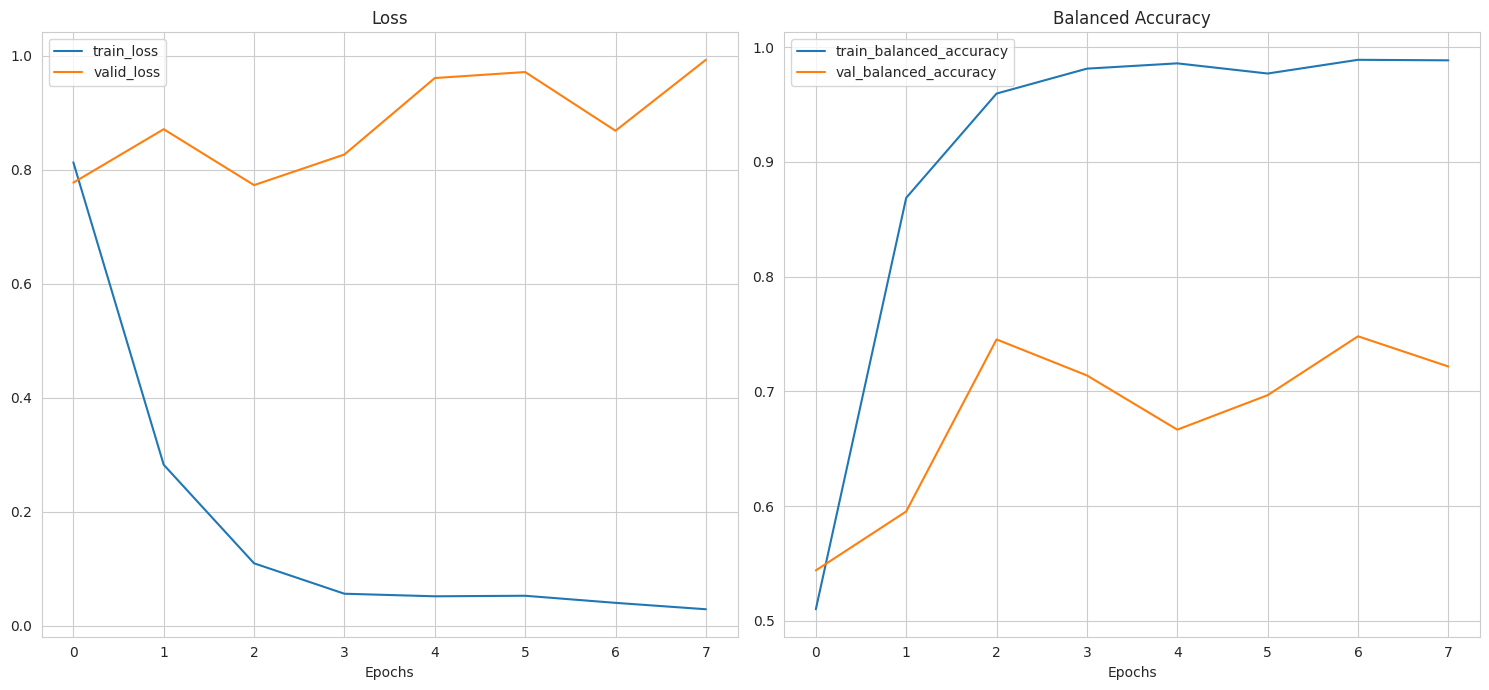

In [44]:
for i in range(len(results_all)):
    helper_functions.plot_loss_curves(results_all[i])
    plt.savefig(f'/content/efficientNet_loss_curves_split_{i}.png')

##Make predictions on images from the test set:


##Create transform with data augmentation:

to improve the performance of our model we will do the data augmentation to make it more generalized

In [45]:
#create training transform with TrivialAugment

#create training transform with TrivialAugment

train_transform_trivial_augment= transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

##Create testing transform (np data augmentation)
test_transform=transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

##Create train and test Dataset's and DataLoader's.


In [46]:

dataset = ImageFolder('/content/Alzheimer_s Dataset/train')

dataset.class_to_idx

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [47]:
def find_classes(dir):
  classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d)) and not d.startswith('.')]
  classes.sort()
  class_to_idx = {classes[i]: i for i in range(len(classes))}
  return classes, class_to_idx

In [48]:
# Turn image folders into Datasets
train_data_augmented = ImageFolder(Train_dir, transform=train_transform_trivial_augment)
test_data_simple = ImageFolder(Test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 5121
     Root location: /content/Alzheimer_s Dataset/train
     StandardTransform
 Transform: Compose(
                Resize(size=(384, 384), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
                ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset ImageFolder
     Number of datapoints: 1279
     Root location: /content/Alzheimer_s Dataset/test
     StandardTransform
 Transform: Compose(
                Resize(size=(384, 384), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ))

In [49]:
BATCH_SIZE=32
NUM_WORKERS =os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented=DataLoader(train_data_augmented,
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      num_workers=NUM_WORKERS)
test_dataloader_simple=DataLoader(test_data_simple,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False,
                                  num_workers=NUM_WORKERS)

train_dataloader_augmented

##Construct and train Model 2

In [50]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#start the timer
from timeit import default_timer as timer
start_time=timer()
result_all=[]
model_.load_state_dict(torch.load('model_weights.pth'))
model_.eval()
for param in model_.features.parameters():
  param.requires_grad=True

# Set the optimizer
optimizer = torch.optim.Adam(model_.parameters(), lr=0.00001)


print('Model was reset')
results2, _ = engine.train_with_early_stopping(model=model_,
                                              train_dataloader=train_dataloader_augmented,
                                              valid_dataloader=test_dataloader_simple,
                                              optimizer=optimizer,
                                              loss_fn=loss_fn,
                                              epochs=5,
                                              device=device)

result_all.append(results2)

end_time=timer()
print(f'[INFO] total training time :{end_time-start_time:.3f} seconds')

Model was reset


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4893 | train_bal_acc: 0.8551 | train_mcc: 0.7558 | valid_loss: 0.8355 | valid_bal_acc: 0.7863 | valid_mcc: 0.0163
Epoch: 2 | train_loss: 0.2992 | train_bal_acc: 0.8898 | train_mcc: 0.8147 | valid_loss: 0.8418 | valid_bal_acc: 0.7695 | valid_mcc: 0.0159
Epoch: 3 | train_loss: 0.2519 | train_bal_acc: 0.9020 | train_mcc: 0.8366 | valid_loss: 0.6690 | valid_bal_acc: 0.7979 | valid_mcc: 0.0171
Epoch: 4 | train_loss: 0.2204 | train_bal_acc: 0.9166 | train_mcc: 0.8670 | valid_loss: 0.6234 | valid_bal_acc: 0.8105 | valid_mcc: 0.0177
Epoch: 5 | train_loss: 0.1864 | train_bal_acc: 0.9334 | train_mcc: 0.8873 | valid_loss: 0.6776 | valid_bal_acc: 0.7999 | valid_mcc: 0.0181
[INFO] total training time :809.204 seconds


   Balanced Acc       MCC  F1 score
0      0.810467  0.017731  0.881777


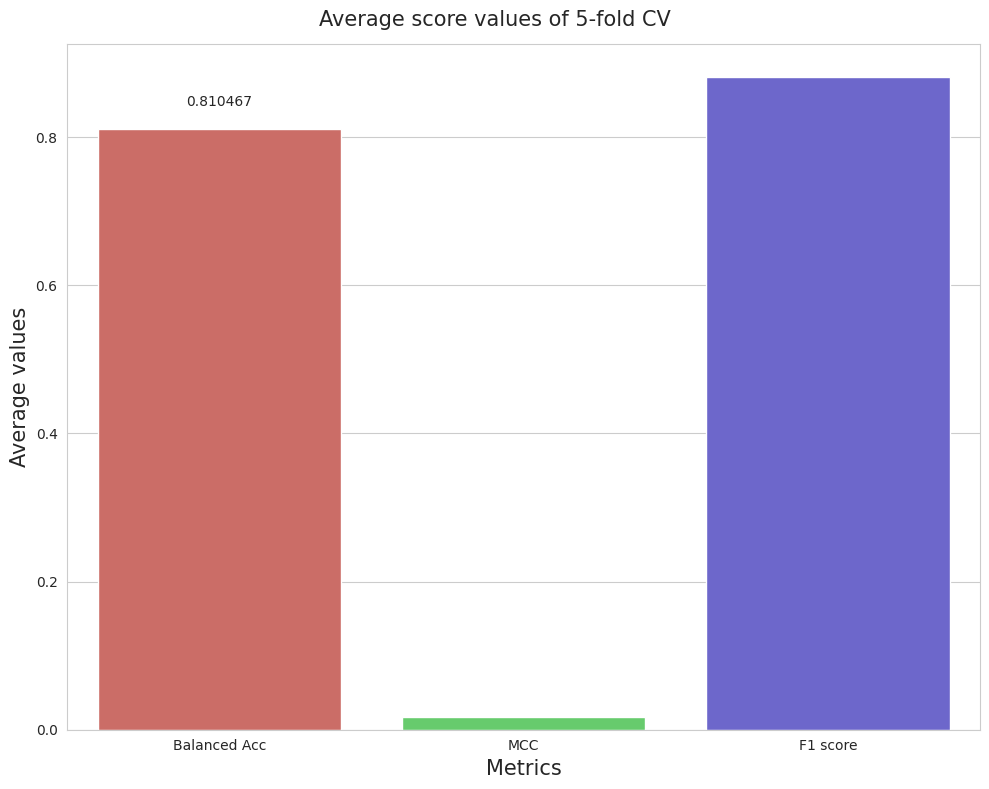

In [51]:

my_dict1 = {'Balanced Acc': [result_all[i]['valid_bal_acc'][result_all[i]['valid_loss'].index(min(result_all[i]['valid_loss']))] for i in range(len(result_all))],
           'MCC': [result_all[i]['valid_mcc'][result_all[i]['valid_loss'].index(min(result_all[i]['valid_loss']))] for i in range(len(result_all))],
           'F1 score': [result_all[i]['valid_f_score'][result_all[i]['valid_loss'].index(min(result_all[i]['valid_loss']))] for i in range(len(result_all))]}

my_df1= pd.DataFrame(my_dict1)
print(my_df1)
plt.rcParams["figure.autolayout"] = True
plt.figure(figsize=(10,8))
sns.set_style('whitegrid')
ax = sns.barplot(data= my_df1, estimator=np.mean, color='blue', palette='hls', errorbar="sd", capsize=.2, errwidth=1.5)
ax.bar_label(ax.containers[0], padding=15)

plt.xlabel('Metrics', fontsize=15)
plt.ylabel(f'Average values', fontsize=15)

plt.suptitle(f'Average score values of 5-fold CV', fontsize=15)
plt.savefig(f'/content/efficientNet2_cv_scores.png')
plt.show()

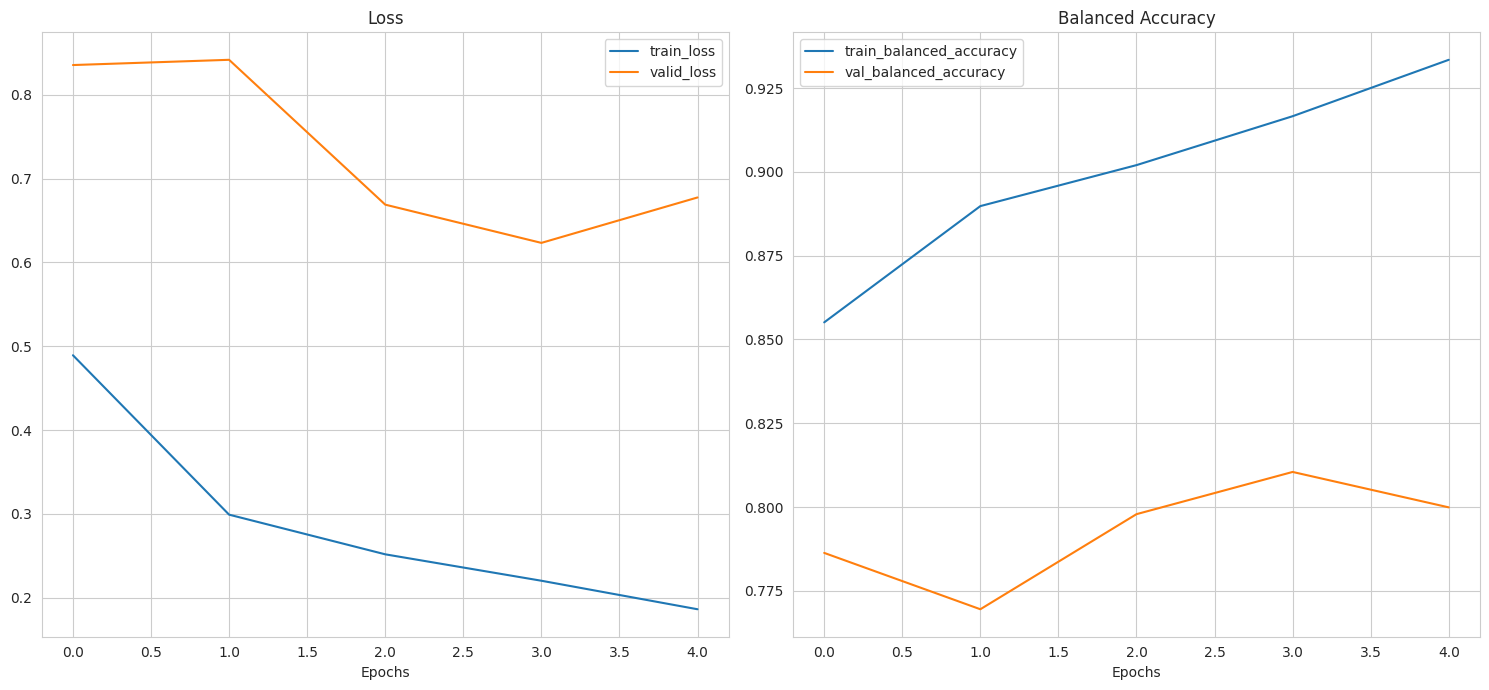

In [52]:
for i in range(len(result_all)):
    helper_functions.plot_loss_curves(result_all[i])
    plt.savefig(f'/content/efficientNet_loss_curves_split_{i}.png')